In [25]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [40]:
X, y = datasets.load_breast_cancer(return_X_y=True)
display(X.shape)
X

(569, 30)

array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)
xg_cl.fit(X_train, y_train)

preds = xg_cl.predict(X_test)
accuracy = float(np.sum(preds==y_test)) / y_test.shape[0]

print("accuracy: %f" % (accuracy))

accuracy: 0.956140


In [27]:
brcr_dmatrix = xgb.DMatrix(data=X, label=y)
params = {'objective': 'binary:logistic', 'max_depth': 4}
cv_results = xgb.cv(dtrain=brcr_dmatrix, params=params, nfold=4, num_boost_round=10, metrics='error', as_pandas=True, seed=123)
cv_results

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.021675,0.002549,0.086218,0.035072
1,0.012887,0.006305,0.066852,0.027570
2,0.008201,0.002026,0.061583,0.030083
3,0.008202,0.001176,0.058062,0.027942
4,0.007029,0.001652,0.058049,0.023086
5,0.005859,0.001175,0.052780,0.022598
6,0.004101,0.001016,0.047486,0.018931
7,0.004101,0.001016,0.051019,0.022527
8,0.003514,0.001170,0.043977,0.018258
9,0.002929,0.001013,0.047498,0.020199


In [29]:
print("Accuracy: %f" % (1 - cv_results['test-error-mean'].iloc[-1]))
print("Accuracy: %f" % (1 - cv_results['test-error-mean'].min()))

Accuracy: 0.952502
Accuracy: 0.956023


In [26]:
# Perform cross_validation: cv_results
cv_results = xgb.cv(dtrain=brcr_dmatrix, params=params, 
                  nfold=4, num_boost_round=10, 
                  metrics="auc", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Print the AUC
print((cv_results["test-auc-mean"]).iloc[-1])

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.992015       0.003258       0.950144      0.031450
1        0.995706       0.000255       0.965678      0.028273
2        0.996053       0.000176       0.974150      0.021867
3        0.998260       0.001195       0.976064      0.020370
4        0.999302       0.000188       0.975936      0.020139
5        0.999551       0.000179       0.984817      0.010540
6        0.999648       0.000227       0.985320      0.009991
7        0.999722       0.000229       0.986399      0.008937
8        0.999859       0.000109       0.988204      0.008218
9        0.999871       0.000125       0.990005      0.005332
0.9900048470227995


In [39]:
classifiers = [LogisticRegression(), SVC()]

for clf in classifiers:
    clf.fit(X_train, y_train)
#    y_scores = cross_val_predict(clf, X_test, y_test, cv=4, method='predict_proba')
    print(f"AUC score: {roc_auc_score(y_test, clf.decision_function(X_test))}")

AUC score: 0.9923154026060808
AUC score: 0.9859672569328433


In [2]:
X, y = datasets.load_boston(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

xg_reg = xgb.XGBRegressor(objective='reg:linear', n_estimators=10, seed=123)
xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)

[17:24:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [5]:
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)

print("RMSE: %f" % (rmse))
mse

RMSE: 3.782443


14.306875845207689

In [6]:
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_test = xgb.DMatrix(data=X_test, label=y_test)
params = {"booster": "gblinear", "objective": "reg:linear"}
xg_api = xgb.train(params=params, dtrain=DM_train, num_boost_round=10)

preds = xg_api.predict(DM_test)

[17:30:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [7]:
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)

print("RMSE: %f" % (rmse))
mse

RMSE: 6.345649


40.26726575731442

In [2]:
df = pd.read_csv("datasets/ames_housing_trimmed_processed.csv")
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,Remodeled,GrLivArea,BsmtFullBath,BsmtHalfBath,...,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,PavedDrive_P,PavedDrive_Y,SalePrice
0,60,65.0,8450,7,5,2003,0,1710,1,0,...,0,0,0,0,1,0,0,0,1,208500
1,20,80.0,9600,6,8,1976,0,1262,0,1,...,0,1,0,0,0,0,0,0,1,181500
2,60,68.0,11250,7,5,2001,1,1786,1,0,...,0,0,0,0,1,0,0,0,1,223500
3,70,60.0,9550,7,5,1915,1,1717,1,0,...,0,0,0,0,1,0,0,0,1,140000
4,60,84.0,14260,8,5,2000,0,2198,1,0,...,0,0,0,0,1,0,0,0,1,250000


In [3]:
X = df.drop("SalePrice", axis=1).values
y = df["SalePrice"]

In [16]:
# Create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(objective="reg:linear", seed=123, n_estimators=10)

# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

# Predict the labels of the test set: preds
preds = xg_reg.predict(X_test)

# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

[17:44:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 28106.463641


In [18]:
# Convert the training and testing sets into DMatrixes: DM_train, DM_test
DM_train = xgb.DMatrix(X_train, y_train)
DM_test =  xgb.DMatrix(X_test, y_test)

# Create the parameter dictionary: params
params = {"booster":"gblinear", "objective":"reg:linear"}

# Train the model: xg_reg
xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=10)

# Predict the labels of the test set: preds
preds = xg_reg.predict(DM_test)

# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("RMSE: %f" % (rmse))

[17:44:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 39921.949285


In [4]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, num_boost_round=10, metrics="rmse", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

[14:17:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:17:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:17:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:17:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0    14176

In [21]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:linear", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, num_boost_round=10, metrics="mae", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results["test-mae-mean"]).tail(1))

[17:49:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
   train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0   127343.480

In [22]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:linear", "max_depth":4}
l1_params = [1,10,100]
rmses_l1 = []

for reg in l1_params:
    params["alpha"] = reg
    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, 
                        num_boost_round=10, metrics="rmse", as_pandas=True, seed=123)
    rmses_l1.append(cv_results["test-rmse-mean"].tail(1).values[0])

print("Best rmse as a function of l1:")
print(pd.DataFrame(list(zip(l1_params, rmses_l1)), columns=["l1", "rmse"]))

[17:59:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:59:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:59:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:59:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:59:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscal

In [25]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}
l1_params = [1,10,100]
rmses_l1 = []

for reg in l1_params:
    params["alpha"] = reg
    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, 
                        num_boost_round=10, metrics="rmse", as_pandas=True, seed=123)
    rmses_l1.append(cv_results["test-rmse-mean"].tail(1).values[0])

print("Best rmse as a function of l1:")
print(pd.DataFrame([*zip(l1_params, rmses_l1)], columns=["l1", "rmse"]))

Best rmse as a function of l1:
    l1          rmse
0    1  35572.514573
1   10  35571.972014
2  100  35572.370621


In [26]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

reg_params = [1, 10, 100]

# Create the initial parameter dictionary for varying l2 strength: params
params = {"objective":"reg:squarederror","max_depth":4}

# Create an empty list for storing rmses as a function of l2 complexity
rmses_l2 = []

# Iterate over reg_params
for reg in reg_params:

    # Update l2 strength
    params["lambda"] = reg
    
    # Pass this updated param dictionary into cv
    cv_results_rmse = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, 
                             num_boost_round=10, metrics="rmse", as_pandas=True, seed=123)
    
    # Append best rmse (final round) to rmses_l2
    rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])

# Look at best rmse per l2 param
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"]))

Best rmse as a function of l2:
    l2          rmse
0    1  35572.510212
1   10  38721.587088
2  100  47549.377910


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

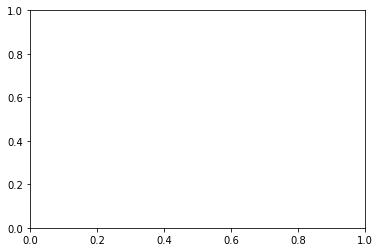

In [18]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":2}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=housing_dmatrix, num_boost_round=10)

# Plot the first tree
xgb.plot_tree(xg_reg, num_trees=0)
#xgb.to_graphviz(xg_reg, num_trees=0)
#plt.show()

# Plot the fifth tree
#xgb.plot_tree(xg_reg, num_trees=4)
xgb.to_graphviz(xg_reg, num_trees=4)
plt.show()

# Plot the last tree sideways
#xgb.plot_tree(xg_reg, num_trees=9, rankdir="LR")
xgb.to_graphviz(xg_reg, num_trees=9, rankdir="LR")
plt.show()

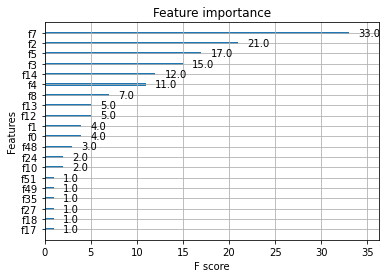

In [10]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective": "reg:squarederror", "max_depth":4}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=housing_dmatrix, num_boost_round=10)

# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.show()

In [5]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [8]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
untuned_params = {"objective":"reg:squarederror"}

# Perform cross-validation: cv_results
untuned_cv_results = xgb.cv(dtrain=housing_dmatrix, params=untuned_params, nfold=4, 
                            num_boost_round=10, metrics="rmse", as_pandas=True, seed=123)

# Print cv_results
print(untuned_cv_results['test-rmse-mean'].tail(1))

9    34624.230446
Name: test-rmse-mean, dtype: float64


In [9]:
tuned_params = {"objective":"reg:squarederror", 'colsample_bytree': 0.3,
                'learning_rate': 0.1, 'max_depth': 5}
tuned_cv_results = xgb.cv(dtrain=housing_dmatrix, params=untuned_params, nfold=4, 
                            num_boost_round=200, metrics="rmse", as_pandas=True, seed=123)
print(tuned_cv_results['test-rmse-mean'].tail(1))

199    33288.916054
Name: test-rmse-mean, dtype: float64


### Tuning the number of boosting rounds

Let's start with parameter tuning by seeing how the number of boosting rounds (number of trees you build) impacts the out-of-sample performance of your XGBoost model. You'll use `xgb.cv()` inside a `for` loop and build one model per `num_boost_round` parameter.

Here, you'll continue working with the Ames housing dataset. The features are available in the array `X`, and the target vector is contained in `y`.

In [11]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary for each tree: params 
params = {"objective":"reg:squarederror", "max_depth":5}

# Create list of number of boosting rounds
num_rounds = [10, 100, 200, 500]

# Empty list to store final round rmse per XGBoost model
final_rmse_per_round = []

# Iterate over num_rounds and build one model per num_boost_round parameter
for curr_num_rounds in num_rounds:

    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, num_boost_round=curr_num_rounds,
                        metrics="rmse", as_pandas=True, seed=123)
    
    # Append final round RMSE
    final_rmse_per_round.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
num_rounds_rmses = list(zip(num_rounds, final_rmse_per_round))
print(pd.DataFrame(num_rounds_rmses,columns=["num_boosting_rounds","rmse"]))

   num_boosting_rounds          rmse
0                   10  34747.695046
1                  100  32933.033251
2                  200  33030.082596
3                  500  33037.761639


### Automated boosting round selection using early_stopping

Now, instead of attempting to cherry pick the best possible number of boosting rounds, you can very easily have XGBoost automatically select the number of boosting rounds for you within `xgb.cv()`. This is done using a technique called **early stopping**.

**Early stopping** works by testing the XGBoost model after every boosting round against a hold-out dataset and stopping the creation of additional boosting rounds (thereby finishing training of the model early) if the hold-out metric (`"rmse"` in our case) does not improve for a given number of rounds. Here you will use the `early_stopping_rounds` parameter in `xgb.cv()` with a large possible number of boosting rounds (50). Bear in mind that if the holdout metric continuously improves up through when `num_boost_rounds` is reached, then early stopping does not occur.

Here, the `DMatrix` and parameter dictionary have been created for you. Your task is to use cross-validation with early stopping. Go for it!

In [12]:
# Create your housing DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary for each tree: params
params = {"objective":"reg:squarederror", "max_depth":5}

# Perform cross-validation with early stopping: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, metrics='rmse',
                        num_boost_round=100, early_stopping_rounds=10, seed=123, as_pandas=True)

# Print cv_results
print(cv_results)

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0     141680.679437      448.444029   142889.640556    1067.003591
1     102591.002777      324.709526   104703.924936    1135.831579
2      75317.777906      276.560359    79075.210107    1653.036722
3      56321.561275      329.945467    61986.688539    2411.977752
4      43042.903052      322.155601    50858.786100    3207.045048
5      33840.308831      354.920262    44041.560383    4071.301499
6      27711.252108      377.556697    39765.119453    4563.142233
7      23366.421755      363.592743    37031.194034    4664.361419
8      20522.006060      266.034064    35783.950291    4953.623285
9      18563.455661      363.471956    34747.695046    4971.479371
10     17263.078114      339.579279    34252.913361    5123.941606
11     16244.110975      321.303754    33852.119647    5110.297884
12     15552.071879      307.712212    33787.832332    5147.652847
13     15042.623024      344.598125    33616.639680    5137.27

### Tuning eta

It's time to practice tuning other XGBoost hyperparameters in earnest and observing their effect on model performance! You'll begin by tuning the `"eta"`, also known as the learning rate.

The learning rate in XGBoost is a parameter that can range between `0` and `1`, with higher values of `"eta"` penalizing feature weights more strongly, causing much stronger regularization.

In [19]:
# Create your housing DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary for each tree (boosting round)
params = {"objective":"reg:squarederror", "max_depth":5}

# Create list of eta values and empty list to store final round rmse per xgboost model
eta_vals = [0.001, 0.01, 0.1]
best_rmse = []

# Systematically vary the eta 
for curr_val in eta_vals:

    params["eta"] = curr_val
    
    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, metrics="rmse",
                            nfold=3, early_stopping_rounds=10, num_boost_round=100,
                            seed=123, as_pandas=True)
        
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(eta_vals, best_rmse)), columns=["eta","best_rmse"]))

     eta      best_rmse
0  0.001  179931.690102
1  0.010   81933.182828
2  0.100   31436.891717


### Tuning max_depth

In this exercise, your job is to tune `max_depth`, which is the parameter that dictates the maximum depth that each tree in a boosting round can grow to. Smaller values will lead to shallower trees, and larger values to deeper trees.

In [20]:
# Create your housing DMatrix
housing_dmatrix = xgb.DMatrix(data=X,label=y)

# Create the parameter dictionary
params = {"objective":"reg:squarederror"}

# Create list of max_depth values
max_depths = [2, 5, 10, 20]
best_rmse = []

# Systematically vary the max_depth
for curr_val in max_depths:

    params["max_depth"] = curr_val
    
    # Perform cross-validation
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, metrics="rmse",
                            nfold=4, early_stopping_rounds=10,
                            num_boost_round=100, seed=123, as_pandas=True)  
    
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(max_depths, best_rmse)),columns=["max_depth","best_rmse"]))

   max_depth     best_rmse
0          2  32189.234108
1          5  32904.160406
2         10  35762.099170
3         20  36278.462084


### Tuning colsample_bytree

Now, it's time to tune `"colsample_bytree"`. You've already seen this if you've ever worked with scikit-learn's `RandomForestClassifier` or `RandomForestRegressor`, where it just was called `max_features`. In both `xgboost` and `sklearn`, this parameter (although named differently) simply specifies the fraction of features to choose from at every split in a given tree. In `xgboost`, `colsample_bytree` must be specified as a float between 0 and 1.

In [22]:
# Create your housing DMatrix
housing_dmatrix = xgb.DMatrix(data=X,label=y)

# Create the parameter dictionary
params={"objective":"reg:squarederror","max_depth":3}

# Create list of hyperparameter values: colsample_bytree_vals
colsample_bytree_vals = [0.1, 0.25, 0.5, 0.75]
best_rmse = []

# Systematically vary the hyperparameter value 
for curr_val in colsample_bytree_vals:

    params["colsample_bytree"] = curr_val
    
    # Perform cross-validation
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4,
                 num_boost_round=100, early_stopping_rounds=10,
                 metrics="rmse", as_pandas=True, seed=123)
    
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(colsample_bytree_vals, best_rmse)), columns=["colsample_bytree","best_rmse"]))

   colsample_bytree     best_rmse
0              0.10  32602.926420
1              0.25  32545.115242
2              0.50  33205.098764
3              0.75  32783.565949


In [23]:
# Create your housing DMatrix
housing_dmatrix = xgb.DMatrix(data=X,label=y)

# Create the parameter dictionary
params={"objective":"reg:squarederror","max_depth":3}

# Create list of hyperparameter values: colsample_bytree_vals
subsamples = [0.1, 0.25, 0.5, 0.75]
best_rmse = []

# Systematically vary the hyperparameter value 
for curr_val in subsamples:

    params["subsample"] = curr_val
    
    # Perform cross-validation
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4,
                 num_boost_round=100, early_stopping_rounds=10,
                 metrics="rmse", as_pandas=True, seed=123)
    
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(subsamples, best_rmse)), columns=["subsample","best_rmse"]))

   subsample     best_rmse
0       0.10  36626.842845
1       0.25  34970.788034
2       0.50  32962.943123
3       0.75  32929.506207


### Grid search with XGBoost

Now that you've learned how to tune parameters individually with `XGBoost`, let's take your parameter tuning to the next level by using scikit-learn's `GridSearch` and `RandomizedSearch` capabilities with internal cross-validation using the `GridSearchCV` and `RandomizedSearchCV` functions. You will use these to find the best model exhaustively from a collection of possible parameter values across multiple parameters simultaneously. Let's get to work, starting with `GridSearchCV`!

In [15]:
housing_dmatrix = xgb.DMatrix(data=X,label=y)
gbm_param_grid = {'learning_rate': [0.01, 0.1, 0.5, 0.9],
                  'colsample_bytree': [0.3, 0.7],
                  'max_depth': [2, 5],
                  'n_estimators': [200],
                  'subsample': [0.3, 0.5, 0.9]}
gbm = xgb.XGBRegressor()
grid_mse = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid, 
                        scoring='neg_mean_squared_error', cv=4, verbose=1, n_jobs=-1)
grid_mse.fit(X, y)

Fitting 4 folds for each of 48 candidates, totalling 192 fits


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.7],
                         'learning_rate': [0.01, 0.1, 0.5, 0.9],
                         'max_depth': [2, 5], 'n_estimators': [200],
                         'subsample': [0.3, 0.5, 0.9]},
             scoring='neg_mean_squared_error', verbose=1)

In [16]:
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Best parameters found:  {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.5}
Lowest RMSE found:  27846.052052074643


### Random search with XGBoost

Often, `GridSearchCV` can be really time consuming, so in practice, you may want to use `RandomizedSearchCV` instead, as you will do in this exercise. The good news is you only have to make a few modifications to your `GridSearchCV` code to do `RandomizedSearchCV`. The key difference is you have to specify a `param_distributions` parameter instead of a `param_grid` parameter.

In [17]:
housing_dmatrix = xgb.DMatrix(data=X,label=y)
gbm_param_grid = {'learning_rate': np.arange(0.05, 1.05, 0.05),
                  'n_estimators': [200],
                  'subsample': np.arange(0.05, 1.05, 0.05),
                  'max_depth': range(1,12)}
gbm = xgb.XGBRegressor()
randomized_mse = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_param_grid, n_iter=25, 
                        scoring='neg_mean_squared_error', cv=4, verbose=1, n_jobs=-1)
randomized_mse.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


RandomizedSearchCV(cv=4,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   n_iter=25, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                                        'max_depth': range(1, 12),
                                        'n_estimators': [200],
                                        'subsample': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                   scoring='neg_mean_squared_error', verbose=1)

In [18]:
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Best parameters found:  {'subsample': 0.5, 'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.25}
Lowest RMSE found:  27613.9462013566


In [21]:
names = ["crime", "zone", "industry", "charles", "no", 
         "rooms", "age", "distance", "radial", "tax", 
         "pupil", "aam", "lower", "med_price"]

data = pd.read_csv("datasets/boston.csv", names=names, skiprows=1)

data.head()

,crime,zone,industry,charles,no,rooms,age,distance,radial,tax,pupil,aam,lower,med_price
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   crime      506 non-null    float64
 1   zone       506 non-null    float64
 2   industry   506 non-null    float64
 3   charles    506 non-null    int64  
 4   no         506 non-null    float64
 5   rooms      506 non-null    float64
 6   age        506 non-null    float64
 7   distance   506 non-null    float64
 8   radial     506 non-null    int64  
 9   tax        506 non-null    float64
 10  pupil      506 non-null    float64
 11  aam        506 non-null    float64
 12  lower      506 non-null    float64
 13  med_price  506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


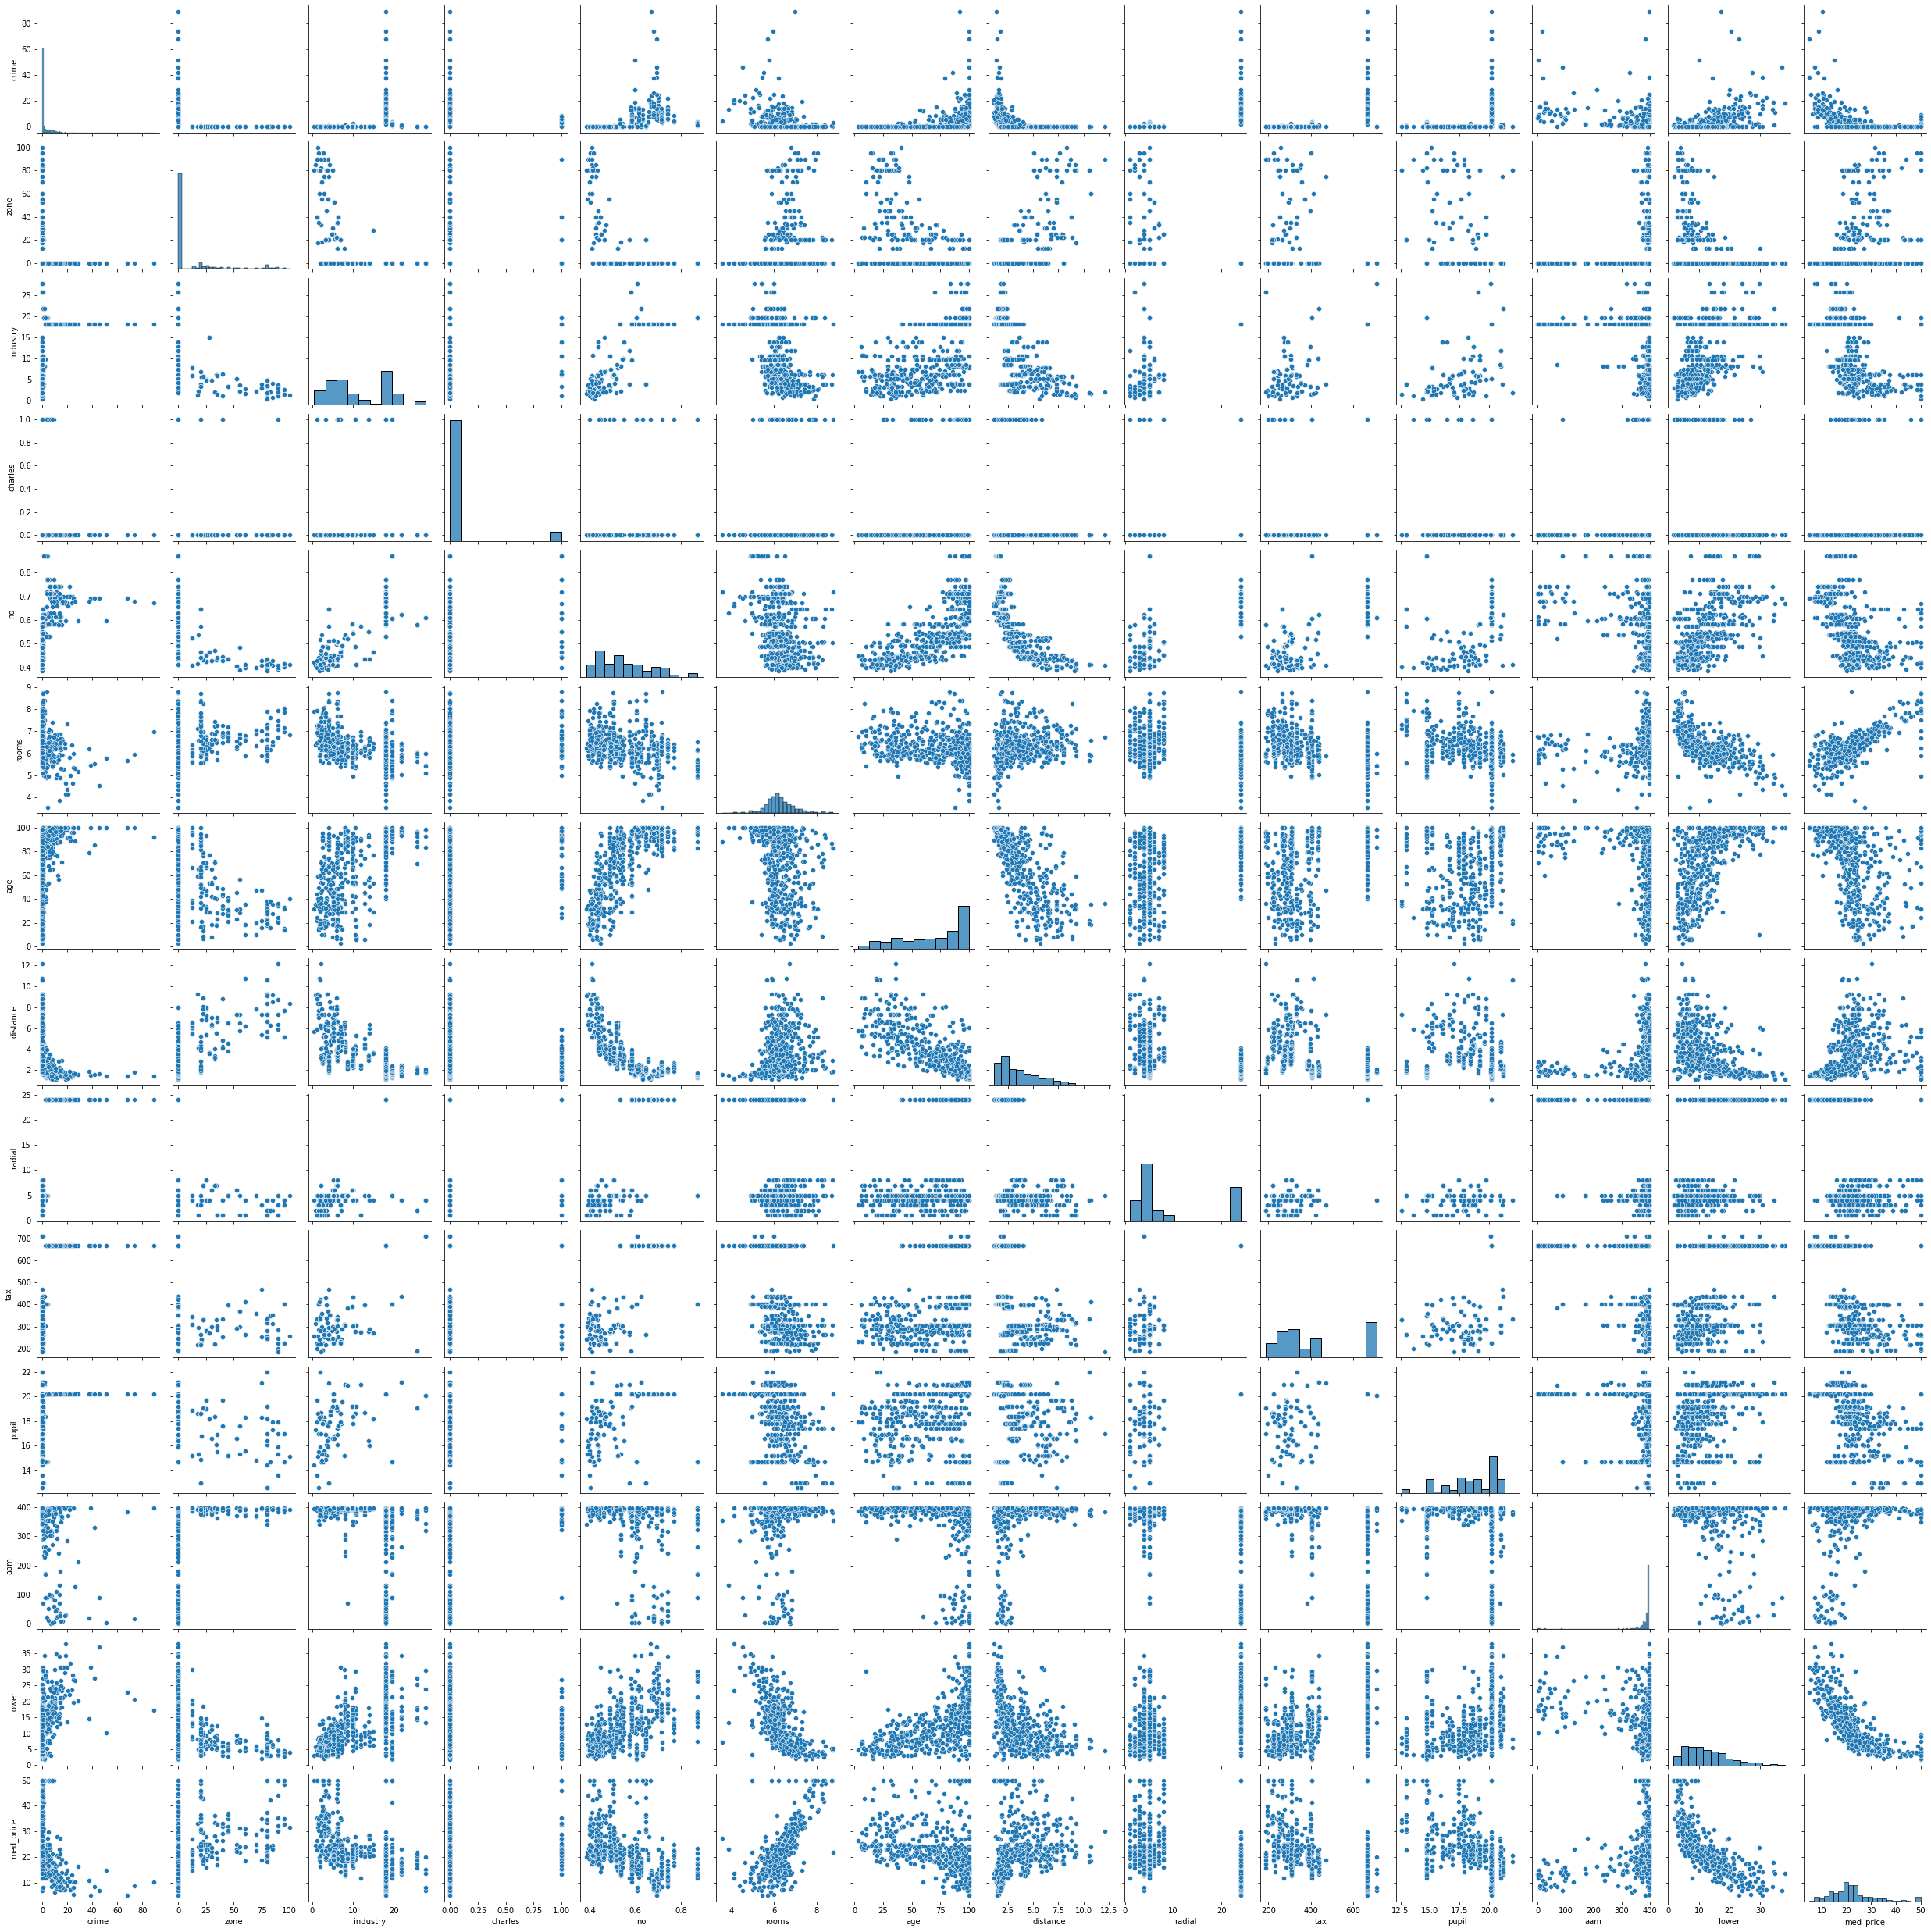

In [26]:
sns.pairplot(data=data)

In [28]:
X, y = data.iloc[:, :-1].values, data.iloc[:,-1].values
X

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [32]:
rf_pipeline = Pipeline([('scaler', StandardScaler()), ('rf_model', RandomForestRegressor())], verbose=True)

scores = cross_val_score(rf_pipeline, X, y, scoring='neg_mean_squared_error', cv=10)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] .......... (step 2 of 2) Processing rf_model, total=   0.4s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] .......... (step 2 of 2) Processing rf_model, total=   0.3s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] .......... (step 2 of 2) Processing rf_model, total=   0.3s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] .......... (step 2 of 2) Processing rf_model, total=   0.3s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] .......... (step 2 of 2) Processing rf_model, total=   0.3s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] .......... (step 2 of 2) Processing rf_model, total=   0.3s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] .......... (step 2 of 2) Processing rf_model, total=   0.3s
[Pipel

In [33]:
final_avg_rmse = np.mean(np.sqrt(np.abs(scores)))

print("Final RMSE: ", final_avg_rmse)

Final RMSE:  4.218638157075943


In [37]:
import os
from pathlib import Path

%reload_ext line_profiler
%%timeit
def count_with_oswalk(path):
    counter = 0
    for base, subdirs, files in os.walk(path):
        for file in files:
            counter += 1
    return counter

print(count_with_oswalk(home))

UsageError: Line magic function `%%timeit` not found.


In [ ]:
def count_with_pathlib(path):
    counter = 0
    for entry in Path(path).iterdir():
        if entry.is_dir():
            counter += count_with_pathlib(entry)
        else:
            counter += 1
    return counter

home = Path.home()

print(count_with_pathlib(home))

In [ ]:

def count_with_scandir(path):
    counter = 0
    for entry in os.scandir(path):
        if entry.is_dir():
            counter += count_with_scandir(entry)
        else:
            counter += 1
    return counter

print(count_with_scandir(home))
